In [12]:
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

np.random.seed(42)
random.seed(42)

Nodes

In [13]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

class Actor:
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.001):
        self.lr = lr
        self.W1 = np.random.randn(state_dim, hidden_dim) * 0.1
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b2 = np.zeros(hidden_dim)
        self.W3 = np.random.randn(hidden_dim, action_dim) * 0.1
        self.b3 = np.zeros(action_dim)

    def forward(self, state):
        self.state = state
        self.z1 = state @ self.W1 + self.b1
        self.a1 = relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = relu(self.z2)
        self.z3 = self.a2 @ self.W3 + self.b3
        self.action = tanh(self.z3)
        return self.action

    def backward(self, grad_output):
        grad_z3 = grad_output * tanh_derivative(self.z3)
        grad_W3 = self.a2.T @ grad_z3
        grad_b3 = np.sum(grad_z3, axis=0)

        grad_a2 = grad_z3 @ self.W3.T
        grad_z2 = grad_a2 * relu_derivative(self.z2)
        grad_W2 = self.a1.T @ grad_z2
        grad_b2 = np.sum(grad_z2, axis=0)

        grad_a1 = grad_z2 @ self.W2.T
        grad_z1 = grad_a1 * relu_derivative(self.z1)
        grad_W1 = self.state.T @ grad_z1
        grad_b1 = np.sum(grad_z1, axis=0)

        self.W1 += self.lr * grad_W1
        self.b1 += self.lr * grad_b1
        self.W2 += self.lr * grad_W2
        self.b2 += self.lr * grad_b2
        self.W3 += self.lr * grad_W3
        self.b3 += self.lr * grad_b3

class Critic:
    def __init__(self, total_state_dim, total_action_dim, hidden_dim=64, lr=0.001):
        self.lr = lr
        input_dim = total_state_dim + total_action_dim
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.1
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.b2 = np.zeros(hidden_dim)
        self.W3 = np.random.randn(hidden_dim, 1) * 0.1
        self.b3 = np.zeros(1)

    def forward(self, states, actions):
        self.input = np.concatenate([states, actions], axis=1)
        self.z1 = self.input @ self.W1 + self.b1
        self.a1 = relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = relu(self.z2)
        self.z3 = self.a2 @ self.W3 + self.b3
        return self.z3

    def backward(self, grad_output):
        grad_z3 = grad_output
        grad_W3 = self.a2.T @ grad_z3
        grad_b3 = np.sum(grad_z3, axis=0)

        grad_a2 = grad_z3 @ self.W3.T
        grad_z2 = grad_a2 * relu_derivative(self.z2)
        grad_W2 = self.a1.T @ grad_z2
        grad_b2 = np.sum(grad_z2, axis=0)

        grad_a1 = grad_z2 @ self.W2.T
        grad_z1 = grad_a1 * relu_derivative(self.z1)
        grad_W1 = self.input.T @ grad_z1
        grad_b1 = np.sum(grad_z1, axis=0)

        self.W1 += self.lr * grad_W1
        self.b1 += self.lr * grad_b1
        self.W2 += self.lr * grad_W2
        self.b2 += self.lr * grad_b2
        self.W3 += self.lr * grad_W3
        self.b3 += self.lr * grad_b3

        return grad_z1 @ self.W1.T

SARSA

In [14]:
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, states, actions, rewards, next_states, dones):
        self.buffer.append((states, actions, rewards, next_states, dones))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

Experimental Agent

In [15]:
class MADDPGAgent:
    def __init__(self, state_dim, action_dim, n_agents, agent_id,
                 lr_actor=0.001, lr_critic=0.001, gamma=0.95, tau=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_agents = n_agents
        self.agent_id = agent_id
        self.gamma = gamma
        self.tau = tau

        self.actor = Actor(state_dim, action_dim, lr=lr_actor)
        self.actor_target = Actor(state_dim, action_dim, lr=lr_actor)
        self._copy_weights(self.actor, self.actor_target)

        total_state_dim = state_dim * n_agents
        total_action_dim = action_dim * n_agents
        self.critic = Critic(total_state_dim, total_action_dim, lr=lr_critic)
        self.critic_target = Critic(total_state_dim, total_action_dim, lr=lr_critic)
        self._copy_weights(self.critic, self.critic_target)

    def _copy_weights(self, source, target):
        target.W1 = source.W1.copy()
        target.b1 = source.b1.copy()
        target.W2 = source.W2.copy()
        target.b2 = source.b2.copy()
        target.W3 = source.W3.copy()
        target.b3 = source.b3.copy()

    def _soft_update(self, source, target):
        target.W1 = self.tau * source.W1 + (1 - self.tau) * target.W1
        target.b1 = self.tau * source.b1 + (1 - self.tau) * target.b1
        target.W2 = self.tau * source.W2 + (1 - self.tau) * target.W2
        target.b2 = self.tau * source.b2 + (1 - self.tau) * target.b2
        target.W3 = self.tau * source.W3 + (1 - self.tau) * target.W3
        target.b3 = self.tau * source.b3 + (1 - self.tau) * target.b3

    def act(self, state, noise=0.1):
        state = np.array(state).reshape(1, -1)
        action = self.actor.forward(state)[0]
        action += noise * np.random.randn(self.action_dim)
        return np.clip(action, -1, 1)

    def update(self, agents, transitions, batch_size=64):
        if len(transitions) < batch_size:
            return 0, 0

        states, actions, rewards, next_states, dones = transitions

        states_arr = np.array(states)
        actions_arr = np.array(actions)
        rewards_arr = np.array(rewards)
        next_states_arr = np.array(next_states)
        dones_arr = np.array(dones)

        batch_size = states_arr.shape[0]
        states_flat = states_arr.reshape(batch_size, -1)
        actions_flat = actions_arr.reshape(batch_size, -1)
        next_states_flat = next_states_arr.reshape(batch_size, -1)

        next_actions = []
        for i, agent in enumerate(agents):
            next_action = agent.actor_target.forward(next_states_arr[:, i])
            next_actions.append(next_action)
        next_actions_flat = np.concatenate(next_actions, axis=1)

        target_q = self.critic_target.forward(next_states_flat, next_actions_flat)
        target_q = rewards_arr[:, self.agent_id:self.agent_id+1] + \
                   self.gamma * target_q * (1 - dones_arr[:, self.agent_id:self.agent_id+1])

        current_q = self.critic.forward(states_flat, actions_flat)
        critic_loss = np.mean((current_q - target_q) ** 2)

        grad_q = 2 * (current_q - target_q) / batch_size
        self.critic.backward(grad_q)

        current_actions = []
        for i, agent in enumerate(agents):
            if i == self.agent_id:
                current_action = self.actor.forward(states_arr[:, i])
            else:
                current_action = actions_arr[:, i]
            current_actions.append(current_action)
        current_actions_flat = np.concatenate(current_actions, axis=1)

        q_value = self.critic.forward(states_flat, current_actions_flat)
        actor_loss = -np.mean(q_value)

        grad_actions = self.critic.backward(-np.ones_like(q_value) / batch_size)
        start_idx = self.agent_id * self.action_dim
        end_idx = start_idx + self.action_dim
        grad_actor = grad_actions[:, start_idx:end_idx]

        self.actor.backward(grad_actor)

        self._soft_update(self.actor, self.actor_target)
        self._soft_update(self.critic, self.critic_target)

        return actor_loss, critic_loss

Environment

In [16]:
class WarehouseEnv:
    def __init__(self, n_robots=3, n_targets=5, grid_size=10, max_capacity=2):
        self.n_robots = n_robots
        self.n_targets = n_targets
        self.grid_size = grid_size
        self.max_capacity = max_capacity
        self.bay = np.array([0.0, 0.0])
        self.depot = np.array([9.0, 9.0])
        self.reset()

    def reset(self):
        self.robot_positions = np.array([self.bay.copy() + np.random.randn(2) * 0.1
                                         for _ in range(self.n_robots)])
        self.robot_loads = np.zeros(self.n_robots, dtype=int)
        self.target_positions = np.random.uniform(2, 8, (self.n_targets, 2))
        self.targets_collected = np.zeros(self.n_targets, dtype=bool)
        self.steps = 0
        self.max_steps = 200
        return self._get_observations()

    def _get_observations(self):
        observations = []
        for i in range(self.n_robots):
            robot_pos = self.robot_positions[i]
            load = self.robot_loads[i] / self.max_capacity

            uncollected = ~self.targets_collected
            if uncollected.any():
                distances = np.linalg.norm(self.target_positions[uncollected] - robot_pos, axis=1)
                closest_idx = np.where(uncollected)[0][np.argmin(distances)]
                closest_target = self.target_positions[closest_idx]
            else:
                closest_target = self.depot

            obs = np.concatenate([
                robot_pos / self.grid_size,
                [load],
                closest_target / self.grid_size,
                self.depot / self.grid_size,
                self.bay / self.grid_size
            ])
            observations.append(obs)

        return np.array(observations)

    def step(self, actions):
        rewards = np.zeros(self.n_robots)

        for i in range(self.n_robots):
            movement = actions[i] * 0.5
            self.robot_positions[i] += movement
            self.robot_positions[i] = np.clip(self.robot_positions[i], 0, self.grid_size)

        for i in range(self.n_robots):
            if self.robot_loads[i] < self.max_capacity:
                for j in range(self.n_targets):
                    if not self.targets_collected[j]:
                        dist = np.linalg.norm(self.robot_positions[i] - self.target_positions[j])
                        if dist < 0.5:
                            self.targets_collected[j] = True
                            self.robot_loads[i] += 1
                            rewards[i] += 10

        for i in range(self.n_robots):
            if self.robot_loads[i] > 0:
                dist = np.linalg.norm(self.robot_positions[i] - self.depot)
                if dist < 0.5:
                    rewards[i] += 20 * self.robot_loads[i]
                    self.robot_loads[i] = 0

        rewards -= 0.1
        self.steps += 1
        done = self.steps >= self.max_steps or self.targets_collected.all()

        return self._get_observations(), rewards, [done] * self.n_robots

    def render(self):
        plt.figure(figsize=(8, 8))
        plt.xlim(-0.5, self.grid_size + 0.5)
        plt.ylim(-0.5, self.grid_size + 0.5)

        bay_circle = patches.Circle(self.bay, 0.5, color='green', alpha=0.3, label='Bay (Start)')
        plt.gca().add_patch(bay_circle)

        depot_circle = patches.Circle(self.depot, 0.5, color='blue', alpha=0.3, label='Depot (Drop-off)')
        plt.gca().add_patch(depot_circle)

        for j, pos in enumerate(self.target_positions):
            if not self.targets_collected[j]:
                plt.plot(pos[0], pos[1], 'r*', markersize=20, label='Target' if j == 0 else '')

        colors = ['orange', 'purple', 'cyan']
        for i, pos in enumerate(self.robot_positions):
            plt.plot(pos[0], pos[1], 'o', markersize=12, color=colors[i % len(colors)],
                    label=f'Robot {i+1} (load: {self.robot_loads[i]})')

        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.title(f'Warehouse Environment - Step {self.steps}')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.show()

Training

In [17]:
def train_maddpg(n_episodes=500, n_robots=3, print_every=50):
    env = WarehouseEnv(n_robots=n_robots)
    state_dim = 9
    action_dim = 2

    agents = [MADDPGAgent(state_dim, action_dim, n_robots, i) for i in range(n_robots)]
    replay_buffer = ReplayBuffer()

    episode_rewards = []

    for episode in range(n_episodes):
        states = env.reset()
        episode_reward = 0
        noise = max(0.1, 1.0 - episode / (n_episodes * 0.5))

        for step in range(env.max_steps):
            actions = []
            for i, agent in enumerate(agents):
                action = agent.act(states[i], noise=noise)
                actions.append(action)
            actions = np.array(actions)

            next_states, rewards, dones = env.step(actions)
            replay_buffer.push(states, actions, rewards, next_states, dones)

            if len(replay_buffer) > 64:
                batch = replay_buffer.sample(64)
                for agent in agents:
                    agent.update(agents, batch)

            states = next_states
            episode_reward += rewards.sum()

            if dones[0]:
                break

        episode_rewards.append(episode_reward)

        if episode % print_every == 0:
            avg_reward = np.mean(episode_rewards[-print_every:])
            print(f"Episode {episode}/{n_episodes} | Avg Reward: {avg_reward:.2f} | Noise: {noise:.3f}")

    plt.figure(figsize=(12, 5))
    plt.plot(episode_rewards, alpha=0.6, label='Episode Reward')
    plt.plot(np.convolve(episode_rewards, np.ones(50)/50, mode='valid'),
             linewidth=2, label='50-episode Moving Avg')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('MADDPG Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return agents, env

Demo

In [18]:
def demo_trained_agents(agents, env, n_episodes=3):
    for episode in range(n_episodes):
        states = env.reset()
        total_reward = 0

        print(f"\n{'='*60}")
        print(f"Demo Episode {episode + 1}")
        print('='*60)

        for step in range(env.max_steps):
            actions = []
            for i, agent in enumerate(agents):
                action = agent.act(states[i], noise=0.0)
                actions.append(action)
            actions = np.array(actions)

            states, rewards, dones = env.step(actions)
            total_reward += rewards.sum()

            if step % 40 == 0:
                print(f"Step {step:3d} | Total Reward: {total_reward:6.2f} | Targets Collected: {env.targets_collected.sum()}/{env.n_targets}")

            if dones[0]:
                break

        print(f"\nFinal Result: Total Reward = {total_reward:.2f}")
        print(f"Targets Collected: {env.targets_collected.sum()}/{env.n_targets}")
        env.render()

Run this

MADDPG Warehouse - Multi-Agent Reinforcement Learning

Algorithm: MADDPG (Multi-Agent Deep Deterministic Policy Gradient)
- Centralized Training, Decentralized Execution
- Off-Policy Learning
- Continuous Action Space

Episode 0/500 | Avg Reward: -40.00 | Noise: 1.000
Episode 50/500 | Avg Reward: -39.60 | Noise: 0.800
Episode 100/500 | Avg Reward: -42.60 | Noise: 0.600
Episode 150/500 | Avg Reward: -48.60 | Noise: 0.400
Episode 200/500 | Avg Reward: -55.80 | Noise: 0.200
Episode 250/500 | Avg Reward: -57.20 | Noise: 0.100
Episode 300/500 | Avg Reward: -56.00 | Noise: 0.100
Episode 350/500 | Avg Reward: -56.60 | Noise: 0.100
Episode 400/500 | Avg Reward: -58.20 | Noise: 0.100
Episode 450/500 | Avg Reward: -57.80 | Noise: 0.100


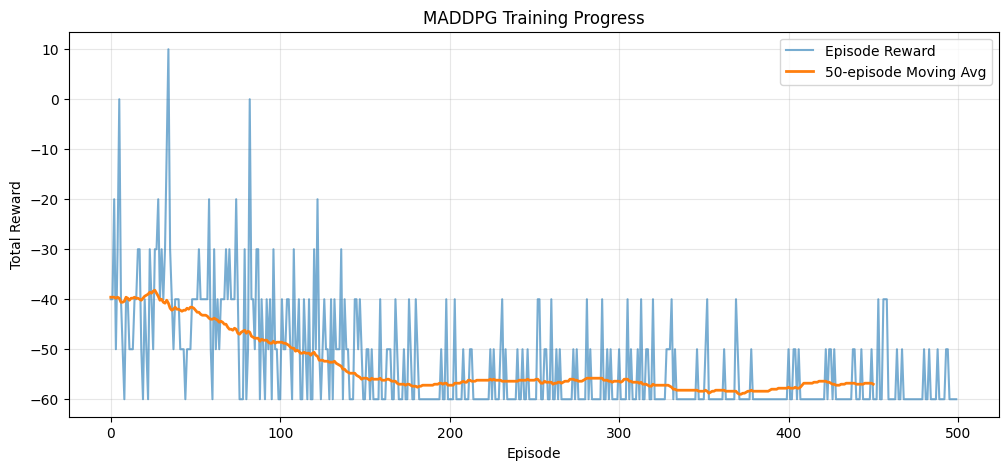


Training Complete! Running Demo Episodes...

Demo Episode 1
Step   0 | Total Reward:  -0.30 | Targets Collected: 0/5
Step  40 | Total Reward: -12.30 | Targets Collected: 0/5
Step  80 | Total Reward: -24.30 | Targets Collected: 0/5
Step 120 | Total Reward: -36.30 | Targets Collected: 0/5
Step 160 | Total Reward: -48.30 | Targets Collected: 0/5

Final Result: Total Reward = -50.00
Targets Collected: 1/5


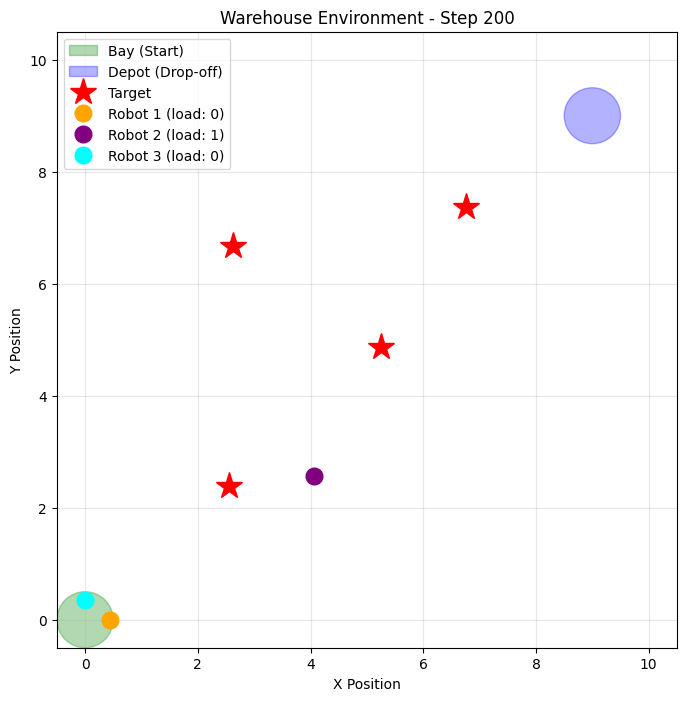


Demo Episode 2
Step   0 | Total Reward:  -0.30 | Targets Collected: 0/5
Step  40 | Total Reward: -12.30 | Targets Collected: 0/5
Step  80 | Total Reward: -24.30 | Targets Collected: 0/5
Step 120 | Total Reward: -36.30 | Targets Collected: 0/5
Step 160 | Total Reward: -48.30 | Targets Collected: 0/5

Final Result: Total Reward = -50.00
Targets Collected: 1/5


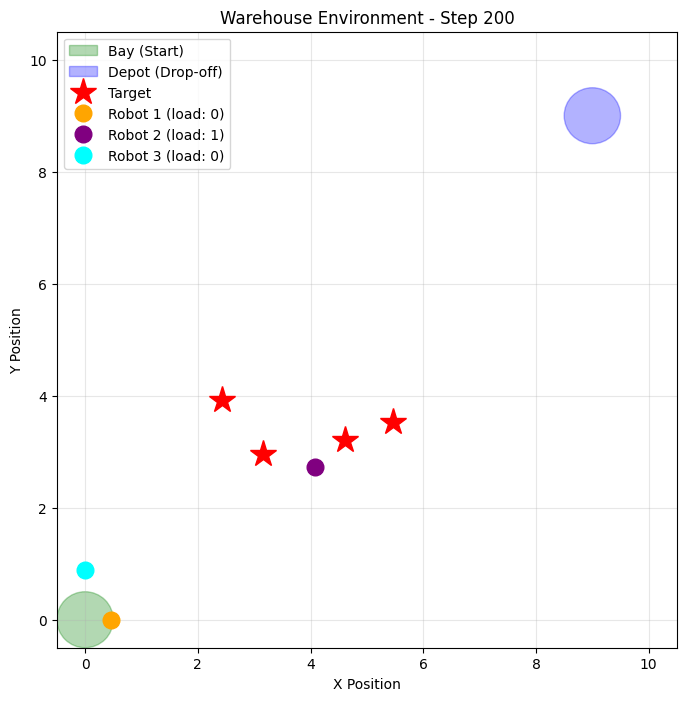

In [19]:
print("=" * 60)
print("MADDPG Warehouse - Multi-Agent Reinforcement Learning")
print("=" * 60)
print("\nAlgorithm: MADDPG (Multi-Agent Deep Deterministic Policy Gradient)")
print("- Centralized Training, Decentralized Execution")
print("- Off-Policy Learning")
print("- Continuous Action Space\n")

# Train the agents
agents, env = train_maddpg(n_episodes=500, n_robots=3, print_every=50)

print("\n" + "="*60)
print("Training Complete! Running Demo Episodes...")
print("="*60)

# Demo the trained agents
demo_trained_agents(agents, env, n_episodes=2)

Experimental Quick Test Code

Episode 0/50 | Avg Reward: -50.00 | Noise: 1.000
Episode 10/50 | Avg Reward: -42.00 | Noise: 0.600
Episode 20/50 | Avg Reward: -57.00 | Noise: 0.200
Episode 30/50 | Avg Reward: -60.00 | Noise: 0.100
Episode 40/50 | Avg Reward: -60.00 | Noise: 0.100


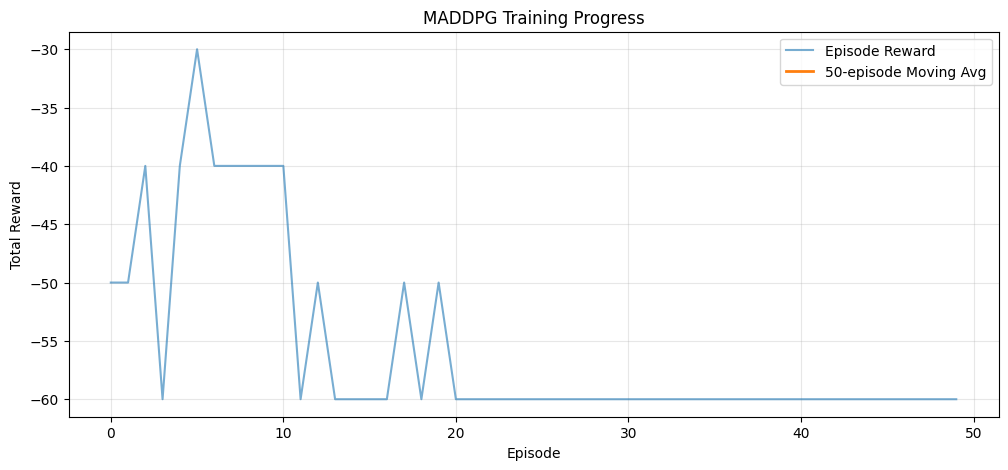


Demo Episode 1
Step   0 | Total Reward:  -0.30 | Targets Collected: 0/5
Step  40 | Total Reward: -12.30 | Targets Collected: 0/5
Step  80 | Total Reward: -24.30 | Targets Collected: 0/5
Step 120 | Total Reward: -36.30 | Targets Collected: 0/5
Step 160 | Total Reward: -48.30 | Targets Collected: 0/5

Final Result: Total Reward = -60.00
Targets Collected: 0/5


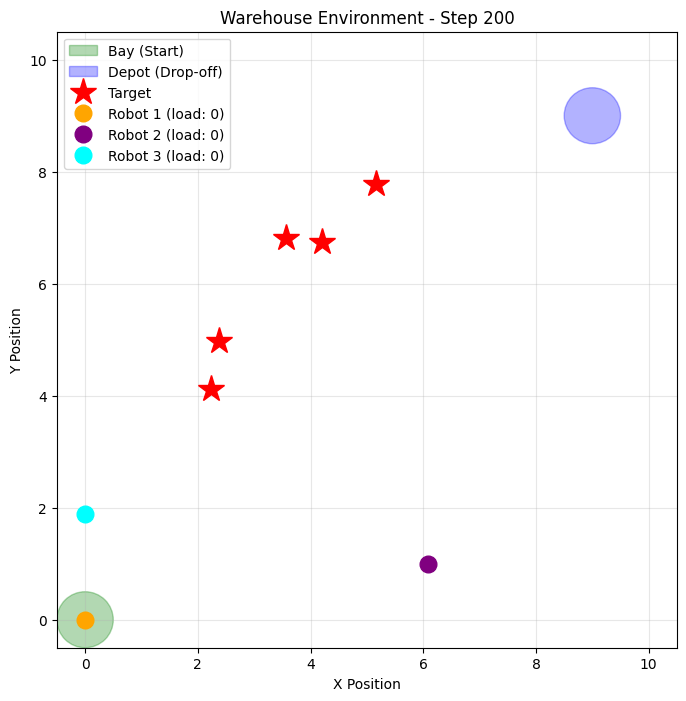

In [20]:
agents_quick, env_quick = train_maddpg(n_episodes=50, n_robots=3, print_every=10)
demo_trained_agents(agents_quick, env_quick, n_episodes=1)